In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from scipy import stats

In [2]:
temp =  pd.read_csv('Gapfilled data/gap_filled_data_ta_rh.csv')
temp['datetime_UTC']=pd.to_datetime(temp['datetime_UTC'])
temp = temp[temp['variable']=='Ta_deg_C']

In [3]:
radii = [10,20,30,40,50,60,70,80,90,100,120,140,160,180,200,250,300,400,500,750,1000,1500,2000,5000,10000]
# loop through saved parquet files and read them into a dictionary
stns_dict = {}
for i in radii:
    stns_dict[f'stns_r{i}'] = gpd.read_parquet(f'stns_r{i}.parquet')

In [4]:
# remove FRTECH from every radius in stns_dict
for i in radii:
    stns_dict[f'stns_r{i}'] = stns_dict[f'stns_r{i}'][stns_dict[f'stns_r{i}']['ID']!='FRTECH']

In [6]:
temp['datetime_UTC'].dt.hour

0         0
1         0
2         0
3         0
4         0
         ..
359442    6
359443    6
359444    6
359445    6
359446    6
Name: datetime_UTC, Length: 359447, dtype: int32

In [13]:
temp['datetime_UTC'].unique()

<DatetimeArray>
['2022-09-01 00:00:00+00:00', '2022-09-01 01:00:00+00:00',
 '2022-09-01 02:00:00+00:00', '2022-09-01 03:00:00+00:00',
 '2022-09-01 04:00:00+00:00', '2022-09-01 05:00:00+00:00',
 '2022-09-01 06:00:00+00:00', '2022-09-01 07:00:00+00:00',
 '2022-09-01 08:00:00+00:00', '2022-09-01 09:00:00+00:00',
 ...
 '2023-08-31 21:00:00+00:00', '2023-08-31 22:00:00+00:00',
 '2023-08-31 23:00:00+00:00', '2023-09-01 00:00:00+00:00',
 '2023-09-01 01:00:00+00:00', '2023-09-01 02:00:00+00:00',
 '2023-09-01 03:00:00+00:00', '2023-09-01 04:00:00+00:00',
 '2023-09-01 05:00:00+00:00', '2023-09-01 06:00:00+00:00']
Length: 8767, dtype: datetime64[ns, UTC]

In [17]:
# perform a regression for each hour of the temp data file with avg_area_height and car in stns_dict[stns_r100]
# save the results in a dictionary
results_car = {}

for i in temp['datetime_UTC'].unique():
    x = stns_dict['stns_r100']['car']
    y = temp[temp['datetime_UTC']==i]['value']
    res = stats.linregress(x, y)
    results_car[i] = res
    

In [74]:
# mask by nan values in avg_area_height of stns_dict['stns_r100'] and perform a regression for each hour of the temp data file with avg_area_height in stns_dict[stns_r100]
# save the results in a dictionary

results_height = {}

for i in temp['datetime_UTC'].unique():
    x = stns_dict['stns_r100']['avg_area_height'].reset_index(drop=True)
    y = temp[temp['datetime_UTC']==i]['value'].reset_index(drop=True)
    mask = x.isna()
    x = x[~mask]
    y = y[~mask]
    res = stats.linregress(x, y)
    results_height[i] = res

In [75]:
results_height

{Timestamp('2022-09-01 00:00:00+0000', tz='UTC'): LinregressResult(slope=0.13164124449825806, intercept=14.367624249594023, rvalue=0.6095307162363157, pvalue=0.0002728418198963553, stderr=0.03179365496779351, intercept_stderr=0.40312470376665016),
 Timestamp('2022-09-01 01:00:00+0000', tz='UTC'): LinregressResult(slope=0.12704633514537064, intercept=14.0765131859764, rvalue=0.5912832959871449, pvalue=0.00046028539142693216, stderr=0.03217751327999717, intercept_stderr=0.4079917996872739),
 Timestamp('2022-09-01 02:00:00+0000', tz='UTC'): LinregressResult(slope=0.139344674286965, intercept=13.49378248219343, rvalue=0.6418655609459781, pvalue=9.940773680393796e-05, stderr=0.03091285672321551, intercept_stderr=0.3919567039948915),
 Timestamp('2022-09-01 03:00:00+0000', tz='UTC'): LinregressResult(slope=0.13854549133413166, intercept=13.12124784096416, rvalue=0.6503783655545069, pvalue=7.473276050997973e-05, stderr=0.030048183466265095, intercept_stderr=0.3809931595104282),
 Timestamp('202

In [76]:
# create a dataframe from results_car with column name eg slope, intercept, rvalue, pvalue, stderr
results_height_df = pd.DataFrame(results_height).T
results_height_df.columns = ['slope', 'intercept', 'rvalue', 'pvalue', 'stderr']


In [77]:
results_height_df

,slope,intercept,rvalue,pvalue,stderr
2022-09-01 00:00:00+00:00,0.131641,14.367624,0.609531,0.000273,0.031794
2022-09-01 01:00:00+00:00,0.127046,14.076513,0.591283,0.000460,0.032178
2022-09-01 02:00:00+00:00,0.139345,13.493782,0.641866,0.000099,0.030913
2022-09-01 03:00:00+00:00,0.138545,13.121248,0.650378,0.000075,0.030048
2022-09-01 04:00:00+00:00,0.117384,12.805333,0.661205,0.000051,0.024732
...,...,...,...,...,...
2023-09-01 02:00:00+00:00,0.017995,18.529612,0.410491,0.021805,0.007423
2023-09-01 03:00:00+00:00,0.017585,18.477662,0.393650,0.028451,0.007626
2023-09-01 04:00:00+00:00,0.025663,17.810708,0.267197,0.146188,0.017186
2023-09-01 05:00:00+00:00,0.025542,18.051811,0.165708,0.372989,0.028227


In [ ]:
# create a dataframe from results_car with column name eg slope, intercept, rvalue, pvalue, stderr
results_car_df = pd.DataFrame(results_car).T
results_car_df.columns = ['slope', 'intercept', 'rvalue', 'pvalue', 'stderr']

In [49]:
# calculate r squared
results_car_df['r_squared'] = results_car_df['rvalue']**2

In [78]:
# calculate r squared
results_height_df['r_squared'] = results_height_df['rvalue']**2

In [50]:
# select all 00:00:00+00:00 timestamps from results_car_df
results_car_df[results_car_df.index.hour==0]


,slope,intercept,rvalue,pvalue,stderr,r_squared
2022-09-01 00:00:00+00:00,5.494989,14.586245,0.658369,2.886593e-06,1.005970,0.433449
2022-09-02 00:00:00+00:00,4.975858,16.491426,0.509882,6.608537e-04,1.344274,0.259980
2022-09-03 00:00:00+00:00,3.760953,15.578265,0.696222,4.315253e-07,0.620923,0.484725
2022-09-04 00:00:00+00:00,4.033429,14.942289,0.504067,7.790511e-04,1.106621,0.254084
2022-09-05 00:00:00+00:00,5.697502,16.071523,0.533933,3.240445e-04,1.444750,0.285085
...,...,...,...,...,...,...
2023-08-28 00:00:00+00:00,2.946283,14.039392,0.662778,2.345491e-06,0.533027,0.439275
2023-08-29 00:00:00+00:00,2.306564,12.004812,0.490347,1.135680e-03,0.656464,0.240440
2023-08-30 00:00:00+00:00,2.315579,12.558909,0.430856,4.920656e-03,0.776611,0.185637
2023-08-31 00:00:00+00:00,2.974001,13.645471,0.610021,2.292977e-05,0.618586,0.372126


In [56]:
results_car_df.to_parquet('results_car_df.parquet')

In [79]:
results_height_df.to_parquet('results_height_df.parquet')

<Axes: >

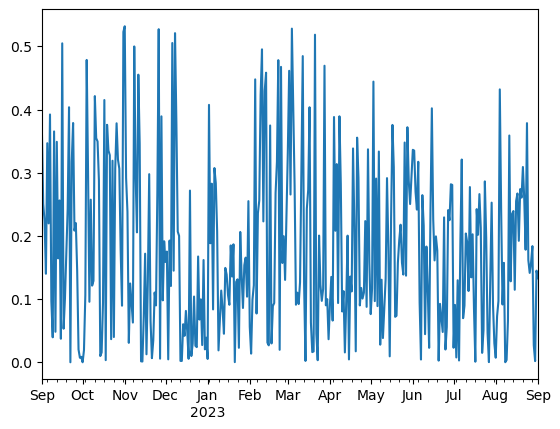

In [81]:
# plot r squared for 00:00:00+00:00
results_height_df[results_car_df.index.hour==0]['r_squared'].plot()

In [39]:
pd.to_datetime(temp['datetime_UTC'].unique())

<DatetimeArray>
['2022-09-01 00:00:00+00:00', '2022-09-01 01:00:00+00:00',
 '2022-09-01 02:00:00+00:00', '2022-09-01 03:00:00+00:00',
 '2022-09-01 04:00:00+00:00', '2022-09-01 05:00:00+00:00',
 '2022-09-01 06:00:00+00:00', '2022-09-01 07:00:00+00:00',
 '2022-09-01 08:00:00+00:00', '2022-09-01 09:00:00+00:00',
 ...
 '2023-08-31 21:00:00+00:00', '2023-08-31 22:00:00+00:00',
 '2023-08-31 23:00:00+00:00', '2023-09-01 00:00:00+00:00',
 '2023-09-01 01:00:00+00:00', '2023-09-01 02:00:00+00:00',
 '2023-09-01 03:00:00+00:00', '2023-09-01 04:00:00+00:00',
 '2023-09-01 05:00:00+00:00', '2023-09-01 06:00:00+00:00']
Length: 8767, dtype: datetime64[ns, UTC]

In [44]:
# select all 00:00:00+00:00 timestamps from results_car
results_car_00 = {k: v for k, v in results_car.items() if k.hour==0}


In [43]:
results_car_00

{Timestamp('2022-09-01 00:00:00+0000', tz='UTC'): LinregressResult(slope=5.494988541757224, intercept=14.58624543431787, rvalue=0.6583685704970259, pvalue=2.8865928062415204e-06, stderr=1.0059695515469111, intercept_stderr=0.22401678004815018),
 Timestamp('2022-09-02 00:00:00+0000', tz='UTC'): LinregressResult(slope=4.9758583060136345, intercept=16.4914261931582, rvalue=0.5098820381517116, pvalue=0.0006608536556149793, stderr=1.3442740246763731, intercept_stderr=0.2993529357298104),
 Timestamp('2022-09-03 00:00:00+0000', tz='UTC'): LinregressResult(slope=3.760952697173882, intercept=15.578265493558437, rvalue=0.6962216178353717, pvalue=4.315252507442389e-07, stderr=0.6209230654928293, intercept_stderr=0.13827176535854008),
 Timestamp('2022-09-04 00:00:00+0000', tz='UTC'): LinregressResult(slope=4.033429350671841, intercept=14.94228850096306, rvalue=0.504067176563448, pvalue=0.000779051099185833, stderr=1.106620664720904, intercept_stderr=0.24643051836341806),
 Timestamp('2022-09-05 00:

In [40]:
temp['datetime_UTC']

0        2022-09-01 00:00:00+00:00
1        2022-09-01 00:00:00+00:00
2        2022-09-01 00:00:00+00:00
3        2022-09-01 00:00:00+00:00
4        2022-09-01 00:00:00+00:00
                    ...           
359442   2023-09-01 06:00:00+00:00
359443   2023-09-01 06:00:00+00:00
359444   2023-09-01 06:00:00+00:00
359445   2023-09-01 06:00:00+00:00
359446   2023-09-01 06:00:00+00:00
Name: datetime_UTC, Length: 359447, dtype: datetime64[ns, UTC]

In [ ]:
temp['datetime_UTC']=pd.to_datetime(temp['datetime_UTC'])

(19236.0, 19237.0)

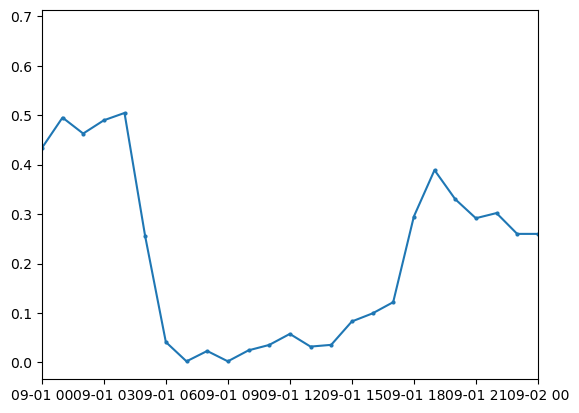

In [33]:
# plot rvalue against time for results_car
rsquared = [i.rvalue**2 for i in results_car.values()]
plt.plot(temp['datetime_UTC'].unique(), rsquared, 'o',linestyle='-', markersize=2)  
plt.xlim(temp['datetime_UTC'].unique()[0], temp['datetime_UTC'].unique()[24])

(19236.0, 19240.0)

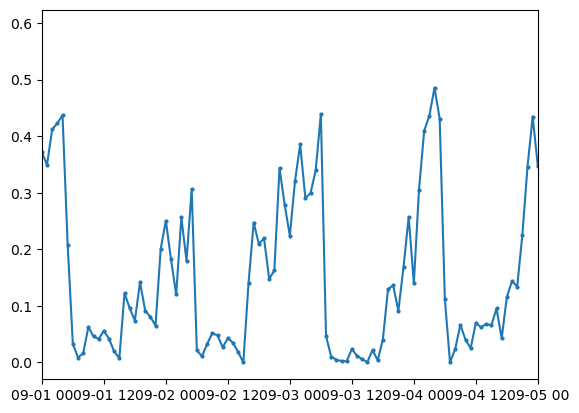

In [85]:
# plot rvalue against time for results_height
rsquared = [i.rvalue**2 for i in results_height.values()]
plt.plot(temp['datetime_UTC'].unique(), rsquared, 'o',linestyle='-', markersize=2)  
plt.xlim(temp['datetime_UTC'].unique()[0], temp['datetime_UTC'].unique()[96])

In [ ]:
# plot rvalue against time for results_car
rsquared = [i.rvalue**2 for i in results_car.values()]
plt.plot(temp['datetime_UTC'].unique(), rsquared, 'o',linestyle='-', markersize=2)  
plt.xlim(temp['datetime_UTC'].unique()[0], temp['datetime_UTC'].unique()[24])

In [ ]:
# plot rvalue against time for results_car
rsquared = [i.rvalue**2 for i in results_car.values()]
plt.plot(temp['datetime_UTC'].unique(), rsquared, 'o',linestyle='-', markersize=2)  
plt.xlim(temp['datetime_UTC'].unique()[0], temp['datetime_UTC'].unique()[100])

In [32]:
rsquared

[0.43344917461829735,
 0.4952078930197566,
 0.46286438717112943,
 0.48968639720538565,
 0.5044911662308462,
 0.2551061202144093,
 0.04133602718789271,
 0.0022757087488566195,
 0.023254049581113986,
 0.002332625772415912,
 0.024536800047202947,
 0.035443869659647936,
 0.05777868191519551,
 0.03211244159095089,
 0.03562667153289337,
 0.08293572854472084,
 0.09924117257332361,
 0.12193547145086113,
 0.2950344559908686,
 0.3889695916534368,
 0.3302616977965307,
 0.2916929500742637,
 0.3020896317365432,
 0.2599994228998614,
 0.25997969282974354,
 0.22710556896455233,
 0.17000363823161516,
 0.3393001079265341,
 0.31347451760463607,
 0.38855470752555504,
 0.08790110040544634,
 0.003251719303652462,
 0.004917590516159034,
 0.001141527953921823,
 0.022650410431826425,
 0.04438397695576558,
 0.03741273175569177,
 0.026930540137660417,
 0.050014527733578625,
 0.17823715608745294,
 0.3174425359892005,
 0.5313636499629392,
 0.44701671969125706,
 0.4897059954783619,
 0.4245106050893354,
 0.346295231